# 10x PBMC fit, whole-dataset, for MoM benchmark


In this notebook, we fit a model with bursty transcription, splicing, and degradation, coupled to length-dependent Poisson model of sequencing. We analyze a single 10x PBMC dataset and consider the effect of using a single method of moments (MoM) initialization vs. MoM plus nine random restarts.

## Prerequisites

Load in *Monod*.


In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

## Metadata

Define metadata and directories.


In [3]:
dataset_meta = ['pbmc_' + x for x in ['1k_v3']]

dataset_names = [x for x in dataset_meta ]  
raw_data_locations = [x for x in dataset_meta]
transcriptome_filepath = '../polyA_ref/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/ggorin/count_data/loom_10x_kb/'+x+'.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)


In [4]:
dataset_names

['pbmc_1k_v3']

## Filtering

Perform a round of filtering based on the knee plot.


In [5]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy


Dataset pbmc_1k_v3. 
	1200 barcodes in loom, 1140 pass filter.


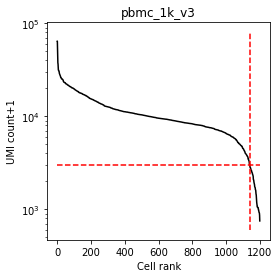

In [6]:
cf = []
thr_lb = [3e3]
fig1,ax1 = plt.subplots(1,1,figsize=(4,4))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[k ]
    dataset_name = raw_data_locations[k ]
        
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1,viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter.')

        cf.append(cf_)

    ax1.set_title(dataset_name)


In [7]:
[x.sum() for x in cf]


[1140]

## Preprocessing

Create a batch and select genes to analyze.


In [8]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_221120_025_pbmc_MoM_1 created.
INFO:root:Dataset: pbmc_1k_v3
INFO:root:1140 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:3088 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221120_025_pbmc_MoM_1/pbmc_1k_v3 created.
INFO:root:Total of 1000 genes selected.
INFO:root:Directory ./fits/gg_221120_025_pbmc_MoM_1/diagnostic_figures created.


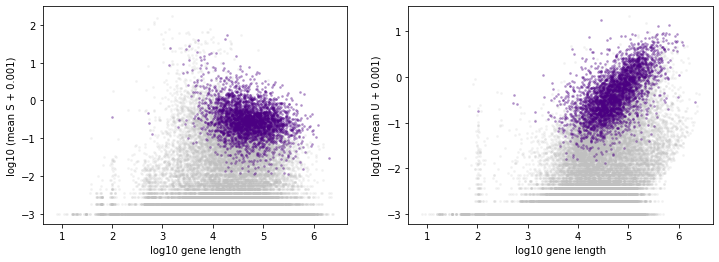

In [9]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='pbmc_MoM',batch_id=1,\
                                             n_genes=1000,exp_filter_threshold=None,cf=cf)


## Inference

Fit the model using a single MoM start.

In [26]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


In [10]:
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [-8, -2.5]
samp_ub = [-5, 0]
gridsize = [10,11]



result_strings = []


INFO:root:Directory ./fits/gg_221120_025_pbmc_MoM_1/pbmc_1k_v3/Bursty_Poisson_10x11 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_221120_025_pbmc_MoM_1/pbmc_1k_v3/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_1k_v3
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_221120_025_pbmc_MoM_1/genes.csv.
INFO:root:Directory ./fits/gg_221120_025_pbmc_MoM_1/pbmc_1k_v3/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221120_025_pbmc_MoM_1/pbmc_1k_v3/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [08:53<00:00,  4.85s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221120_025_pbmc_MoM_1/pbmc_1k_v3/Bursty_Poisson_10x11/analysis_figures created.
INFO:root:Runtime: 539.2 seconds.


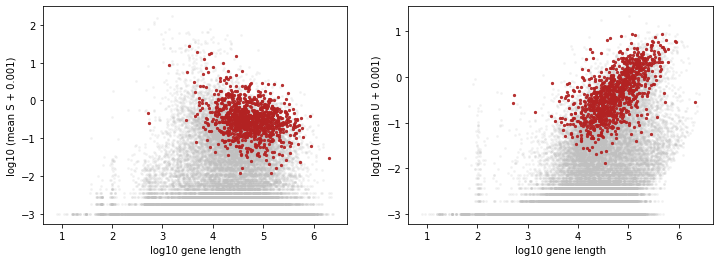

In [13]:
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(40,search_data)
    result_strings.append(full_result_string)


Move the results to a dedicated directory.

In [14]:
!mv /home/ggorin/projects/GP_2021_3/notebooks/fits/gg_221120_025_pbmc_MoM_1/pbmc_1k_v3/Bursty_Poisson_10x11 /home/ggorin/projects/GP_2021_3/notebooks/fits/gg_221120_025_pbmc_MoM_1/pbmc_1k_v3/Bursty_Poisson_10x11_1rest

Fit the model using ten starts.

INFO:root:Directory ./fits/gg_221120_025_pbmc_MoM_1/pbmc_1k_v3/Bursty_Poisson_10x11 created.
INFO:root:Global inference parameters stored to ./fits/gg_221120_025_pbmc_MoM_1/pbmc_1k_v3/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_1k_v3
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_221120_025_pbmc_MoM_1/genes.csv.
INFO:root:Directory ./fits/gg_221120_025_pbmc_MoM_1/pbmc_1k_v3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_221120_025_pbmc_MoM_1/pbmc_1k_v3/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [59:25<00:00, 32.42s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221120_025_pbmc_MoM_1/pbmc_1k_v3/Bursty_Poisson_10x11/analysis_figures created.
INFO:root:Runtime: 3566.3 seconds.


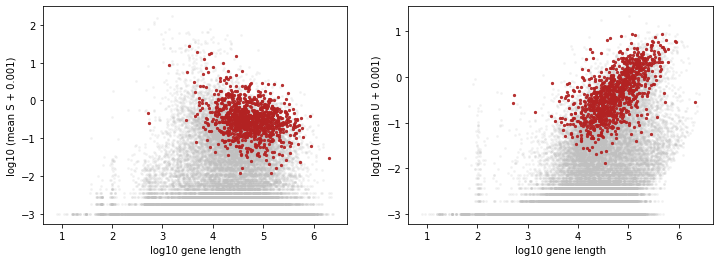

In [15]:
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':10})
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(40,search_data)
    result_strings.append(full_result_string)


Move the results to a dedicated directory.

In [16]:
!mv /home/ggorin/projects/GP_2021_3/notebooks/fits/gg_221120_025_pbmc_MoM_1/pbmc_1k_v3/Bursty_Poisson_10x11 /home/ggorin/projects/GP_2021_3/notebooks/fits/gg_221120_025_pbmc_MoM_1/pbmc_1k_v3/Bursty_Poisson_10x11_10rest

In [11]:
dir_string

'./fits/gg_221120_025_pbmc_MoM_1'